In [1]:
import torch
import pandas as pd
import os

In [2]:
class TitlePartyModel(torch.nn.Module):
    def __init__(self):
        super(TitlePartyModel, self).__init__()
        self.input = torch.nn.Linear(2048,2048, dtype=torch.float32)
        self.input_activation = torch.nn.Sigmoid()
        self.hidden1 = torch.nn.Linear(2048,1024)
        self.hidden1_activation = torch.nn.Sigmoid()
        self.hidden2 = torch.nn.Linear(1024,128)
        self.hidden2_activation = torch.nn.Sigmoid()
        # 4 political party choices
        self.hidden3 = torch.nn.Linear(128,4)
        self.output = torch.nn.Softmax()

    def forward(self, x):
        x = self.input(x)
        x = self.input_activation(x)
        x = self.hidden1(x)
        x = self.hidden1_activation(x)
        x = self.hidden2(x)
        x = self.hidden2_activation(x)
        x = self.hidden3(x)
        x = self.output(x)
        return x



In [3]:
title_model = TitlePartyModel()
print("the model")
print(title_model)
print("just the 2nd layer")
print(title_model.hidden1)
print("parameters")
for p in title_model.parameters():
    print(p)
print("2nd layer params")
for p in title_model.hidden1.parameters():
    print(p)

the model
TitlePartyModel(
  (input): Linear(in_features=2048, out_features=2048, bias=True)
  (input_activation): Sigmoid()
  (hidden1): Linear(in_features=2048, out_features=1024, bias=True)
  (hidden1_activation): Sigmoid()
  (hidden2): Linear(in_features=1024, out_features=128, bias=True)
  (hidden2_activation): Sigmoid()
  (hidden3): Linear(in_features=128, out_features=4, bias=True)
  (output): Softmax(dim=None)
)
just the 2nd layer
Linear(in_features=2048, out_features=1024, bias=True)
parameters
Parameter containing:
tensor([[-1.8922e-02, -2.0408e-02,  1.7578e-02,  ..., -3.8541e-03,
          7.4127e-03,  1.7878e-02],
        [ 1.3443e-02,  1.5858e-02,  3.0428e-03,  ...,  1.5453e-02,
         -1.2433e-02, -2.0525e-02],
        [-1.7320e-03, -1.4576e-02, -5.1307e-03,  ...,  9.2729e-03,
         -8.4456e-03, -1.8161e-02],
        ...,
        [ 1.0821e-02,  5.6869e-03, -1.4725e-02,  ...,  2.9255e-05,
         -5.3993e-03, -1.1066e-02],
        [ 1.8139e-02,  1.4515e-02,  1.7283e-

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import fnmatch
import numpy as np

In [5]:
train_files = []
validate_files = []
test_files = []
split = 0.6
token_path = os.path.join(os.getcwd(),"..","data","tokenized")
print(token_path)
for root, dirs, files in os.walk(token_path):
    for f in files:
        if fnmatch.fnmatch(f, "*maxpool*"):
            if np.random.sample(1) <= split:
                print(f'train: {f}')
                train_files.append(os.path.join(root, f))
            elif np.random.sample(1) < 0.5:
                print(f'validate {f}')
                validate_files.append(os.path.join(root, f))
            else:
                print(f'test : {f}')
                test_files.append(os.path.join(root, f))
print(train_files)
print(test_files)

C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized
test : summary_bill_1811_1392983-maxpool.pkl
validate summary_bill_1811_1392984-maxpool.pkl
train: summary_bill_1811_1392985-maxpool.pkl
train: summary_bill_1811_1392986-maxpool.pkl
train: summary_bill_1811_1392988-maxpool.pkl
validate summary_bill_1811_1392989-maxpool.pkl
train: summary_bill_1811_1392990-maxpool.pkl
test : summary_bill_1811_1392991-maxpool.pkl
train: summary_bill_1811_1392992-maxpool.pkl
train: summary_bill_1811_1392994-maxpool.pkl
test : summary_bill_1811_1392995-maxpool.pkl
train: summary_bill_1811_1392996-maxpool.pkl
train: summary_bill_1811_1392997-maxpool.pkl
train: summary_bill_1811_1393000-maxpool.pkl
train: summary_bill_1811_1393001-maxpool.pkl
train: summary_bill_1811_1393002-maxpool.pkl
validate summary_bill_1811_1393003-maxpool.pkl
validate summary_bill_1811_1393005-maxpool.pkl
validate summary_bill_1811_1393007-maxpool.pkl
train: summary_bill_1811_1393008-maxpool.pk

In [6]:
class SummaryDataSet(torch.utils.data.Dataset):
    def __init__(self, file_path_arr, fixed_idx=False, allow_gpu=False):
        self.data_frames = []
        self.fixed_idx = fixed_idx
        self.allow_gpu = allow_gpu
        for f in file_path_arr:
            print(f"loading {f}")
            self.data_frames.append(pd.read_pickle(f, compression="gzip"))
        if torch.cuda.is_available() and allow_gpu:
            self.t_device = f'cuda:{torch.cuda.current_device()}'
        else:
            self.t_device = 'cpu'
        print(f"device set to {self.t_device}")



    def __len__(self):
        if self.fixed_idx:
            return 1
        else:
            return len(self.data_frames)

    def __getitem__(self, idx):
        if self.fixed_idx:
            next_df = self.data_frames[0]
        else:
            next_df = self.data_frames[idx]
        party = next_df["party"][0] # they are all the same, so just pick the first one
        encoding = torch.tensor(np.array(next_df["input_maxpool"]),dtype=torch.float, device=self.t_device)
        # 4 politcal party choices
        party_arr = np.zeros(4,dtype=int)
        # the party index was stored as value with a starting index of 1 -- rethink this
        party_arr[party-1] = 1 # set the value to 1 for the party index
        return encoding, torch.tensor(party_arr,dtype=torch.float, device=self.t_device)

We want to run a sanity check that our training code is working my overfitting on a single record

In [7]:
from torch.utils.data import DataLoader
single_train_data_set = SummaryDataSet(train_files,fixed_idx=True)
single_validate_data_set = SummaryDataSet(train_files,fixed_idx=True)
single_test_data_set = SummaryDataSet(train_files,fixed_idx=True)
single_train_loader = DataLoader(single_train_data_set,batch_size=1,shuffle=False)
single_validate_loader = DataLoader(single_validate_data_set, batch_size=1, shuffle=False)
single_test_loader = DataLoader(single_test_data_set, batch_size=1, shuffle=False)

loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392985-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392986-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392988-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392990-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392992-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392994-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392996-maxpool.pkl
loading C:\Users\benja\git-project

In [8]:
def train_one_epoch(model, loss_function, the_optimizer, summary_writer, training_dataloader, scheduler=None):
    running_loss = 0
    last_loss = 0.
    for i, data in enumerate(training_dataloader):
        inputs, label = data
        input_tensor = inputs.view(1,-1)
        outputs = model(input_tensor)
        loss = loss_function(outputs, label)
        last_loss = loss.item()
        optimizer.step()
        the_optimizer.zero_grad()
        loss.backward()
        if scheduler != None:
            scheduler.step()
        summary_idx = i * len(training_dataloader) + i + 1
        summary_writer.add_scalar("loss/train", last_loss, summary_idx)
    return last_loss

In [9]:
title_model = TitlePartyModel()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(title_model.parameters(), lr=0.001, momentum=0.9)

In [10]:
import datetime
from torch.utils.tensorboard import SummaryWriter
def run_epochs(max_epoch, model, loss_function, optimizer, training_dataloader, validation_dataloader, scheduler = None):
    start_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    writer = SummaryWriter('runs/fashion_trainer_{}'.format(start_time))
    epoch_num = 0
    val_losses = []
    train_losses = []
    for epoch in range(max_epoch):
        print(f"epoch {epoch}")
        print("turn on training")
        model.train(True)
        print("running one epoch")
        last_epoch_loss = train_one_epoch(model,loss_function, optimizer, writer, training_dataloader, scheduler)
        train_losses.append(last_epoch_loss)
        print("turn off training")
        print(f'epoch loss {last_epoch_loss}')

        # title_model.train(False)

        running_validation_loss = 0.0
        print("applying model.eval()")
        model.eval()
        with (torch.no_grad()):
            for i, vdata in enumerate(validation_dataloader):
                # print(f"validation {i}")
                vinputs, vlabel = vdata
                # print(f"label : {vlabel}")
                voutputs = model(vinputs)
                # print(f"vOutput: {voutputs}")
                vloss = loss_fn(voutputs, vlabel)
                running_validation_loss += vloss

        avg_vloss = running_validation_loss / len(validation_dataloader)
        val_losses.append(avg_vloss)
        print('LOSS train {} valid {}'.format(last_epoch_loss, avg_vloss))
    #    writer.add_scalars("Training vs Valiation loss",{"training": last_epoch_loss, "validation": avg_vloss}, epoch_num+1)
    #    writer.flush()
        epoch_num += 1
    return (train_losses, val_losses)

So let's train for 100 epochs. Generally you would monitor the losses and stop when there no further improvements

In [11]:
single_item_model = TitlePartyModel()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(single_item_model.parameters(), lr=0.001, momentum=0.9)
single_train_losses, single_validation_losses = run_epochs(100, single_item_model, loss_fn, optimizer, single_train_loader, single_validate_loader)

epoch 0
turn on training
running one epoch
turn off training
epoch loss 0.16214923560619354
applying model.eval()
LOSS train 0.16214923560619354 valid 0.16214923560619354
epoch 1
turn on training
running one epoch


C:\Users\benja\AppData\Local\Temp\ipykernel_29368\2359741441.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 4]], which is output 0 of AsStridedBackward0, is at version 2; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [ ]:
single_val_loss_values = list(map(lambda x : x.item(), single_validation_losses))
single_train_losses[-1]

In [26]:
from matplotlib import pyplot as plt

In [ ]:
plt.plot(range(100), single_val_loss_values)
plt.yscale('log')
plt.title("validation loss vs epoch")
plt.show()

In [ ]:
plt.plot(range(100), single_train_losses)
plt.yscale('log')
plt.title("training loss vs epoch")
plt.show()

Now let's run for all the train and validate data

In [13]:
full_val_losses = []
full_train_losses = []
full_model = TitlePartyModel()
full_loss_fn = torch.nn.MSELoss()
full_optimizer = torch.optim.RMSprop(full_model.parameters(), lr=0.001, momentum=0.9)
full_train_dataset = SummaryDataSet(train_files)
full_validate_dataset = SummaryDataSet(validate_files)
full_test_dataset = SummaryDataSet(test_files)
full_train_loader =  DataLoader(full_train_dataset,batch_size=1,shuffle=True)
full_validate_loader = DataLoader(full_validate_dataset, batch_size=1, shuffle=True)
full_test_loader = DataLoader(full_test_dataset, batch_size=1, shuffle=True)

loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392985-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392986-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392988-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392990-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392992-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392994-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392996-maxpool.pkl
loading C:\Users\benja\git-project

In [15]:
# by pass training if our checkpoint exist
if os.path.exists("full_model.pkl"):
    full_model.load_state_dict(torch.load("full_model.pkl"))
    loss_df = pd.DataFrame({"train_losses": full_train_losses,
                  "validation_losses": full_val_losses})
    full_train_losses = loss_df["train_losses"]
    full_validate_losses = loss_df["validation_losses"]
else:
    full_train_losses, full_validate_losses = run_epochs(100, full_model, full_loss_fn, full_optimizer, full_train_loader, full_validate_loader)

In [130]:
# save the model
torch.save(full_model.state_dict(),"full_model.pkl")
len(full_val_losses)
loss_df = pd.DataFrame({"train_losses": full_train_losses,
              "validation_losses": full_validate_losses})
loss_df.to_pickle("full_model_loss.pkl", compression="gzip")

In [16]:
full_val_loss_values = list(map(lambda x : x.item(), full_validate_losses))
full_train_losses[-1]

KeyError: -1

0
[]


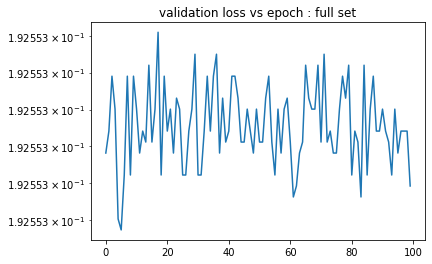

In [124]:
print(len(full_val_losses))
print(full_val_losses)
plt.plot(range(100), full_val_loss_values)
plt.yscale('log')
plt.title("validation loss vs epoch : full set")
plt.show()

In [131]:
torch.cuda.is_available()

True

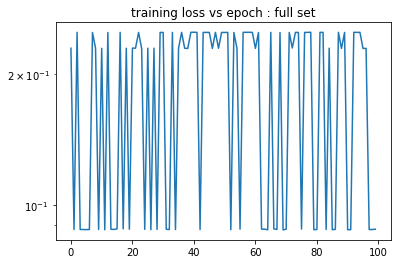

In [125]:
plt.plot(range(100), full_train_losses)
plt.yscale('log')
plt.title("training loss vs epoch : full set")
plt.show()

Let's try full with learning rate decay

In [17]:
import pytorch_warmup as warmup
full_lrd_val_losses = []
full_lrd_train_losses = []
full_lrd_model = TitlePartyModel()
if torch.cuda.is_available():
    full_lrd_model.cuda()
full_lrd_loss_fn = torch.nn.MSELoss()
full_lrd_optimizer = torch.optim.RMSprop(full_lrd_model.parameters(), lr=0.1, momentum=0.9)
lrd_schedulers = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5,10,15,20], gamma=0.95)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
full_gpu_train_dataset = SummaryDataSet(train_files, allow_gpu=True)
full_gpu_validate_dataset = SummaryDataSet(validate_files, allow_gpu=True)
full_gpu_test_dataset = SummaryDataSet(test_files, allow_gpu=True)
full_gpu_train_loader =  DataLoader(full_gpu_train_dataset,batch_size=1,shuffle=True)
full_gpu_validate_loader = DataLoader(full_gpu_validate_dataset, batch_size=1, shuffle=True)
full_gpu_test_loader = DataLoader(full_gpu_test_dataset, batch_size=1, shuffle=True)

loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392985-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392986-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392988-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392990-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392992-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392994-maxpool.pkl
loading C:\Users\benja\git-projects\bitbucket\nlp_legislation_prediction\training\..\data\tokenized\summary_bill_1811_1392996-maxpool.pkl
loading C:\Users\benja\git-project

In [45]:
lrd_schedulers = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=range(30), gamma=0.95)


In [46]:
for p in full_lrd_model.parameters():
    print(p.device)

cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0
cuda:0


In [47]:
for t, l in full_gpu_test_loader:
    print(t.device,l.device)

cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0 cuda:0
cuda:0

In [48]:
full_lrd_train_losses, full_lrd_validate_losses = run_epochs(30, full_lrd_model, full_lrd_loss_fn, full_lrd_optimizer, full_gpu_train_loader, full_gpu_validate_loader)

epoch 0
turn on training
running one epoch


C:\Users\benja\AppData\Local\Temp\ipykernel_29368\2359741441.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.output(x)


turn off training
epoch loss 0.20887693762779236
applying model.eval()
LOSS train 0.20887693762779236 valid 0.18476925790309906
epoch 1
turn on training
running one epoch
turn off training
epoch loss 0.20901980996131897
applying model.eval()
LOSS train 0.20901980996131897 valid 0.18476925790309906
epoch 2
turn on training
running one epoch
turn off training
epoch loss 0.21506743133068085
applying model.eval()
LOSS train 0.21506743133068085 valid 0.18476933240890503
epoch 3
turn on training
running one epoch
turn off training
epoch loss 0.215218648314476
applying model.eval()
LOSS train 0.215218648314476 valid 0.18476922810077667
epoch 4
turn on training
running one epoch
turn off training
epoch loss 0.15037602186203003
applying model.eval()
LOSS train 0.15037602186203003 valid 0.18476930260658264
epoch 5
turn on training
running one epoch
turn off training
epoch loss 0.15064112842082977
applying model.eval()
LOSS train 0.15064112842082977 valid 0.18476922810077667
epoch 6
turn on train

In [49]:
torch.save(full_lrd_model.state_dict(),"full_lrd_model.pkl")
full_lrd_validate_losses_cpu = [x.cpu().item() for x in full_lrd_validate_losses]
loss_df = pd.DataFrame({"full_lrd_train_losses": full_lrd_train_losses,
              "validation_losses": full_lrd_validate_losses_cpu})
loss_df.to_pickle("full_lrd_model.pkl_loss.pkl", compression="gzip")
full_lrd_train_losses_prev = full_lrd_train_losses
full_lrd_validate_losses_prev = full_lrd_validate_losses_cpu

In [50]:
full_lrd_val_loss_values = list(map(lambda x : x.item(), full_lrd_validate_losses))
full_lrd_train_losses[-1]

0.15055425465106964

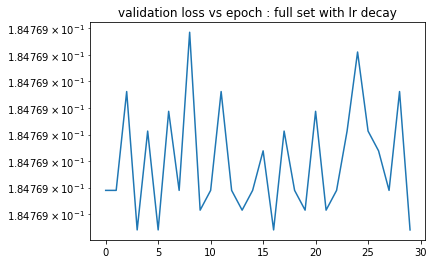

In [52]:
plt.plot(range(30), full_lrd_val_loss_values)
plt.yscale('log')
plt.title("validation loss vs epoch : full set with lr decay")
plt.show()

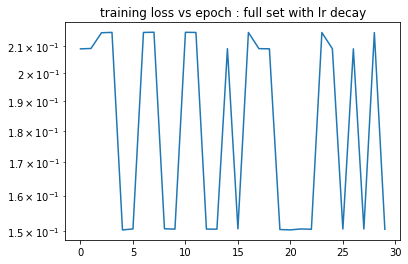

In [53]:
plt.plot(range(30), full_lrd_train_losses)
plt.yscale('log')
plt.title("training loss vs epoch : full set with lr decay")
plt.show()

In [56]:
class TitlePartyModelRelu(torch.nn.Module):
    def __init__(self):
        super(TitlePartyModelRelu, self).__init__()
        self.input = torch.nn.Linear(2048,2048, dtype=torch.float32)
        self.input_activation = torch.nn.ReLU()
        self.hidden1 = torch.nn.Linear(2048,1024)
        self.hidden1_activation = torch.nn.ReLU()
        self.hidden2 = torch.nn.Linear(1024,128)
        self.hidden2_activation = torch.nn.ReLU()
        # 4 political party choices
        self.hidden3 = torch.nn.Linear(128,4)
        self.output = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.input(x)
        x = self.input_activation(x)
        x = self.hidden1(x)
        x = self.hidden1_activation(x)
        x = self.hidden2(x)
        x = self.hidden2_activation(x)
        x = self.hidden3(x)
        x = self.output(x)
        return x

In [57]:
full_lrd_relu_val_losses = []
full_lrd_train_relu_losses = []
full_lrd_relu_model = TitlePartyModelRelu()
if torch.cuda.is_available():
    full_lrd_relu_model.cuda()
full_lrd_relu_loss_fn = torch.nn.MSELoss()
full_lrd_relu_optimizer = torch.optim.RMSprop(full_lrd_model.parameters(), lr=0.1, momentum=0.9)
# warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)

In [60]:
lrd_relu_schedulers = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=range(50, 2), gamma=0.95)

In [61]:
full_lrd_relu_train_losses, full_lrd_relu_validate_losses = run_epochs(50, full_lrd_relu_model, full_lrd_relu_loss_fn, full_lrd_relu_optimizer, full_gpu_train_loader, full_gpu_validate_loader, lrd_relu_schedulers)

epoch 0
turn on training
running one epoch
turn off training
epoch loss 0.1884552389383316
applying model.eval()
LOSS train 0.1884552389383316 valid 0.1906021684408188
epoch 1
turn on training
running one epoch
turn off training
epoch loss 0.19386662542819977
applying model.eval()
LOSS train 0.19386662542819977 valid 0.19060222804546356
epoch 2
turn on training
running one epoch
turn off training
epoch loss 0.1907583773136139
applying model.eval()
LOSS train 0.1907583773136139 valid 0.19060227274894714
epoch 3
turn on training
running one epoch
turn off training
epoch loss 0.1881299465894699
applying model.eval()
LOSS train 0.1881299465894699 valid 0.19060228765010834
epoch 4
turn on training
running one epoch
turn off training
epoch loss 0.19058409333229065
applying model.eval()
LOSS train 0.19058409333229065 valid 0.19060222804546356
epoch 5
turn on training
running one epoch
turn off training
epoch loss 0.19318732619285583
applying model.eval()
LOSS train 0.19318732619285583 valid 0

In [62]:
torch.save(full_lrd_relu_model.state_dict(),"full_lrd_relu_model.pkl")
full_lrd_relu_validate_losses_cpu = [x.cpu().item() for x in full_lrd_relu_validate_losses]
loss_df = pd.DataFrame({"full_lrd_train_losses": full_lrd_relu_train_losses,
              "validation_losses": full_lrd_relu_validate_losses_cpu})
loss_df.to_pickle("full_lrd_model_relu_loss.pkl", compression="gzip")
full_lrd_relu_train_losses_prev = full_lrd_train_losses
full_lrd_relu_validate_losses_prev = full_lrd_validate_losses_cpu

In [63]:
full_lrd_relu_val_loss_values = list(map(lambda x : x.item(), full_lrd_relu_validate_losses))
full_lrd_relu_train_losses[-1]

0.19246774911880493

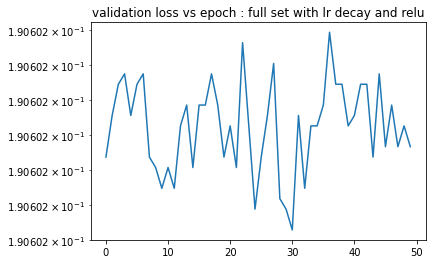

In [65]:
plt.plot(range(50), full_lrd_relu_val_loss_values)
plt.yscale('log')
plt.title("validation loss vs epoch : full set with lr decay and relu")
plt.show()

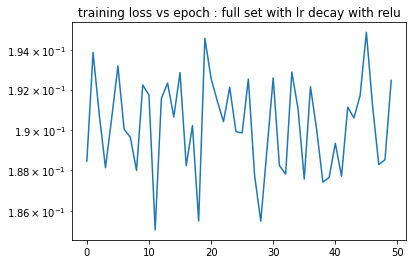

In [66]:
plt.plot(range(50), full_lrd_relu_train_losses)
plt.yscale('log')
plt.title("training loss vs epoch : full set with lr decay with relu")
plt.show()